<a href="https://colab.research.google.com/github/danielalcalde/MCMC_CRBM/blob/master/Ising_CRBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulating the Ising model using a CRBM

## Abstract:
Machine learning is becoming widely used in analyzing the thermodynamics of many-body condensed matter systems. Restricted Boltzmann Machine (RBM) aided Monte Carlo simulations have sparked interest recently, as they manage to speed up classical Monte Carlo simulations. Here we employ the Convolutional Restricted Boltzmann Machine (CRBM) method and show that its use helps to reduce the number of parameters to be learned drastically by taking advantage of translation invariance. Furthermore, we show that it is possible to train the CRBM at smaller lattice sizes, and apply it to larger lattice sizes. To demonstrate the efficiency of CRBM we apply it to the paradigmatic Ising and Kitaev models in two-dimensions.

## Paper:
https://arxiv.org/abs/2008.05401

## Introduction
This Notebook is intended as an educational tool for the use of Convolutional Restricted Boltzmann Machines in classical Montecarlo simulations. The code for the paper was written with the library Theano, which will no longer be updated, that is why we have chosen to present the main concept in TensorFlow. Specifically, this notebook only tackles the Ising model. As there is only the nearest neighbor interaction, we can teach the CRBM using $3\times3$ states, this has as a consequence that we can generate all possible states $2^{3\times3}= 512$ and learn the energy function from them. So no Metropolis is necessary, and no sampling of the CRBM while training is necessary. Also contrary to the main work, for simplicity, no correction step or parallel tempering is introduced. Note that for the Ising model there exist cluster algorithms that would outperform the CRBM.


# Installing tensorflow

In [51]:
"""
### install necessary packages if in colab
def run_subprocess_command(cmd):
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    for line in process.stdout:
        print(line.decode().strip())


import sys, subprocess

IN_COLAB = "google.colab" in sys.modules
colab_requirements = ["pip install tensorflow-gpu==2.1.0"]
if IN_COLAB:
    for i in colab_requirements:
        run_subprocess_command(i)
""";

# Importing necessary libraries

In [52]:
import numpy as np
import tensorflow as tf
from IPython import display
import pandas as pd
import time
import matplotlib.pyplot as plt

Set seed for reproducibility.

In [53]:
np.random.seed(0)
tf.random.set_seed(0)

Accuracy used for training and numerics.

In [54]:
floatX = np.float32

In [55]:
t0 = time.time()

# Helping functions

Tensorflow has no implementation of the binomial function. With help of random.uniform the beahviour can be replicated.

In [56]:
def binomial(means):
    return (tf.sign(means - tf.random.uniform(tf.shape(means))) + 1 ) / 2

In [57]:
binomial(np.array([0.5, 0.5, 0.1, 0.9]))

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([1., 1., 0., 1.], dtype=float32)>

This functions creates periodic padding so that the convolution has periodic boundary conditions. When performing the transposed convolution step the padding is placed at the oposite side.

In [58]:
def periodic_padding(x, kernel_size=2, deconv=False):
    '''
    x: shape (batch_size, d1, d2)
    return x padded with periodic boundaries. i.e. torus or donut
    '''
    pad_r = kernel_size // 2
    pad_l = kernel_size - pad_r - 1
    
    d1, d2 = x.shape[1: 3]
    
    # When deconvolving the pading should reverses
    if deconv:
        p = pad_r
        pad_r = pad_l
        pad_l = p   

    top_left = x[:, d1 - pad_l:, d2 - pad_l:]
    top_center = x[:, d1 - pad_l:, :]
    top_right = x[:, d1 - pad_l:, :pad_r]

    middle_left = x[:, :, d2 - pad_l:]
    middle_center = x
    middle_right = x[:, :, :pad_r]

    bottom_left = x[:, :pad_r, d2 - pad_l:]
    bottom_center = x[:, :pad_r, :]
    bottom_right = x[:, :pad_r, :pad_r]
    
    top = tf.concat([top_left, top_center, top_right], axis=2)
    middle = tf.concat([middle_left, middle_center, middle_right], axis=2)
    bottom = tf.concat([bottom_left, bottom_center, bottom_right], axis=2)
    padded_x = tf.concat([top, middle, bottom], axis=1)
    return padded_x

a = tf.Variable(np.arange(4 * 4).reshape(1, 4, 4))
print(a[0].numpy())
print()
print(periodic_padding(a)[0].numpy())

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]

[[ 0  1  2  3  0]
 [ 4  5  6  7  4]
 [ 8  9 10 11  8]
 [12 13 14 15 12]
 [ 0  1  2  3  0]]


In [59]:
print(periodic_padding(a,5)[0].numpy())

[[10 11  8  9 10 11  8  9]
 [14 15 12 13 14 15 12 13]
 [ 2  3  0  1  2  3  0  1]
 [ 6  7  4  5  6  7  4  5]
 [10 11  8  9 10 11  8  9]
 [14 15 12 13 14 15 12 13]
 [ 2  3  0  1  2  3  0  1]
 [ 6  7  4  5  6  7  4  5]]


# Dataset Generation

In [60]:
def to_int(x):
    if x == '0' or x == '1': return int(x)
    else: return 0

#This will generate all posible LxL matrices with {0,1}^(LxL) don't use with more then L=4
def bit_string(L):
    maxim = 2 ** (L ** 2)
    a = np.asarray([[to_int(x) for x in list(('{0:' + str(L ** 2) + 'b}').format(i))] for i in range(maxim)], dtype=floatX)
    return a.reshape(2 ** (L ** 2), L, L)

Generate all posible $3\times3$ states

In [61]:
states_train = bit_string(3)[:, :, :, None]
states_train.shape

(512, 3, 3, 1)

Generate a random test set of lattice size $L=50$ to evaluate if the CRBM matches the Ising model at large lattice sizes.

In [201]:
L = 2
states_test = np.asarray(np.random.binomial(size=(4 * 10 ** 3, L, L, 1), p=0.5, n=1), dtype=floatX)
states_test = np.asarray(np.random.binomial(size=(1, L, L, 1), p=0.5, n=1), dtype=floatX)
states_test.shape

(1, 2, 2, 1)

In [202]:
states_test[0][0][0] # Each of these vertical groups is an Ising lattice row from top to bottom

array([1.], dtype=float32)

Define the energy of given state for the Ising model: $E(s)=-\sum_{<ij>}s_is_j$

In [203]:
def ising_energy(states):
    states = 2 * states - 1

    nb = np.roll(states, shift=-1, axis=1) + np.roll(states, shift=-1, axis=2)

    return -np.sum(states * nb, axis=(1, 2, 3))

For now we will only consider the case $T=1$


In [204]:
v1 = states_test
ising_energy(v1)

array([-0.], dtype=float32)

In [205]:
v1

array([[[[1.],
         [0.]],

        [[1.],
         [1.]]]], dtype=float32)

In [206]:
temp = 1.

The physical energy is computed for train and test set.

In [207]:
E_phys_train = ising_energy(states_train)
E_phys_test = ising_energy(states_test)
E_phys_train.shape,E_phys_test.shape

((512,), (1,))

The CRBM will be trained by batches of 64 states.

In [208]:
TRAIN_BUF = E_phys_train.shape[0] # Not sure what train buffer means.  it might just be total of training samples
BATCH_SIZE = 2 ** 6 # = 64
N_TRAIN_BATCHES = TRAIN_BUF// BATCH_SIZE

train_dataset = tf.data.Dataset.from_tensor_slices((states_train, E_phys_train)).shuffle(TRAIN_BUF).batch(BATCH_SIZE)

In [209]:
N_TRAIN_BATCHES

8

# The Model

Random Initializion: the kernel W with kernel_dims=(kernel_number, kernel_size) and both biases.

In [210]:
kernel_number = 2
kernel_size = 2

In [211]:
kernel_dims = (kernel_number, kernel_size)
kernel_shape = (kernel_dims[1], kernel_dims[1], 1, kernel_dims[0]) # kernel must have dims, like input.

multi = np.prod(kernel_shape)
W_np = np.asarray(np.random.randn(*kernel_shape) * np.sqrt(2 / multi), dtype=floatX)

W = tf.Variable(W_np * 2)

vbias = tf.Variable(np.zeros(1, dtype=floatX)) # visible bias
hbias = tf.Variable(np.zeros(kernel_dims[0], dtype=floatX)) # hidden layer biases

print("vbias.shape:", vbias.shape)
print("hbias.shape:", hbias.shape)
print("W.shape:", W.shape)

vbias.shape: (1,)
hbias.shape: (2,)
W.shape: (2, 2, 1, 2)


In [212]:
W_np

array([[[[-0.4936914 , -1.0144186 ]],

        [[ 0.19440372, -0.3635338 ]]],


       [[[-0.0043832 , -0.6845626 ]],

        [[ 0.4543611 , -0.45574197]]]], dtype=float32)

In [213]:
W

<tf.Variable 'Variable:0' shape=(2, 2, 1, 2) dtype=float32, numpy=
array([[[[-0.9873828 , -2.0288372 ]],

        [[ 0.38880745, -0.7270676 ]]],


       [[[-0.0087664 , -1.3691252 ]],

        [[ 0.9087222 , -0.91148394]]]], dtype=float32)>

In [214]:
W_np[0] # gives back W^{k=0}

array([[[-0.4936914 , -1.0144186 ]],

       [[ 0.19440372, -0.3635338 ]]], dtype=float32)

In [215]:
W_np[0][0] # gives back first row of W^{k=0}

array([[-0.4936914, -1.0144186]], dtype=float32)

In [216]:
W_np[0][0][0] # STILL gives back first row of W^{k=0}

array([-0.4936914, -1.0144186], dtype=float32)

In [217]:
W_np[0][0][0][0] # gives back first element of first row of W^{k=0}

-0.4936914

In [218]:
W 

<tf.Variable 'Variable:0' shape=(2, 2, 1, 2) dtype=float32, numpy=
array([[[[-0.9873828 , -2.0288372 ]],

        [[ 0.38880745, -0.7270676 ]]],


       [[[-0.0087664 , -1.3691252 ]],

        [[ 0.9087222 , -0.91148394]]]], dtype=float32)>

The negative log likelihood also called free energy: \\
$F(v) = -v_\text{bias} \sum_{i,j} v_{ij} -\sum_{i,j,k} \log(1+e^{(v*W^k)_{ij} +h^k_\text{bias}})$

In [219]:
v1

array([[[[1.],
         [0.]],

        [[1.],
         [1.]]]], dtype=float32)

In [220]:
periodic_padding(v1,2)

<tf.Tensor: shape=(1, 3, 3, 1), dtype=float32, numpy=
array([[[[1.],
         [0.],
         [1.]],

        [[1.],
         [1.],
         [1.]],

        [[1.],
         [0.],
         [1.]]]], dtype=float32)>

In [276]:
W

<tf.Variable 'Variable:0' shape=(2, 2, 1, 2) dtype=float32, numpy=
array([[[[-0.9873828 , -2.0288372 ]],

        [[ 0.38880745, -0.7270676 ]]],


       [[[-0.0087664 , -1.3691252 ]],

        [[ 0.9087222 , -0.91148394]]]], dtype=float32)>

In [305]:
W[0][0][0][1]

<tf.Tensor: shape=(), dtype=float32, numpy=-2.0288372>

In [222]:
vbias

<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>

In [223]:
hbias

<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>

In [346]:
def n_log_like(v):
    input4D = periodic_padding(v, kernel_dims[1])
    kernels4D = W

    # Convolution
    # print("LOL")
    out = tf.nn.conv2d(input4D, kernels4D, strides=1, padding="VALID") # VALID uses only input data, no extra points added since they were already added by hand
    # print(input4D)
    # print(kernels4D)
    hbias_test = tf.Variable(np.floor(np.random.random(kernel_dims[0])*10),dtype=floatX) # hidden layer biases
    out += hbias[None, None, None, :]
    print(out)

    # Same as softplus(x)=log(1 + exp(x))
    hidden_term_not = tf.math.softplus(out)
    print("hidden_term_not: ",hidden_term_not)
    hidden_term = tf.reduce_sum(hidden_term_not, axis=(1, 2, 3))
    print("hidden_term: ",hidden_term)
    
    # This is just a sum over visible neurons done for each batch and input.
    visible_term = tf.reduce_sum(v, axis=(1, 2)) * vbias[None, :]
    visible_term = tf.reduce_sum(visible_term, axis=1)

    return -hidden_term - visible_term

In [273]:
v1,v1[0],v1[0][0]

(array([[[[1.],
          [0.]],
 
         [[1.],
          [1.]]]], dtype=float32),
 array([[[1.],
         [0.]],
 
        [[1.],
         [1.]]], dtype=float32),
 array([[1.],
        [0.]], dtype=float32))

In [264]:
v1padded = periodic_padding(v1, kernel_dims[1])[0]
v1padded # Just to check, but padding actually will happen inside n_log_like()

<tf.Tensor: shape=(3, 3, 1), dtype=float32, numpy=
array([[[1.],
        [0.],
        [1.]],

       [[1.],
        [1.],
        [1.]],

       [[1.],
        [0.],
        [1.]]], dtype=float32)>

In [265]:
n_log_like(v1)

LOL
tf.Tensor(
[[[[1.]
   [0.]
   [1.]]

  [[1.]
   [1.]
   [1.]]

  [[1.]
   [0.]
   [1.]]]], shape=(1, 3, 3, 1), dtype=float32)
<tf.Variable 'Variable:0' shape=(2, 2, 1, 2) dtype=float32, numpy=
array([[[[-0.9873828 , -2.0288372 ]],

        [[ 0.38880745, -0.7270676 ]]],


       [[[-0.0087664 , -1.3691252 ]],

        [[ 0.9087222 , -0.91148394]]]], dtype=float32)>
tf.Tensor(
[[[[-0.08742702 -4.3094463 ]
   [ 1.2887633  -3.0076768 ]]

  [[-0.60734177 -4.12503   ]
   [ 0.31014687 -3.6673887 ]]]], shape=(1, 2, 2, 2), dtype=float32)


<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-3.580499], dtype=float32)>

In [347]:
n_log_like(v1)

tf.Tensor(
[[[[-0.08742702 -4.3094463 ]
   [ 1.2887633  -3.0076768 ]]

  [[-0.60734177 -4.12503   ]
   [ 0.31014687 -3.6673887 ]]]], shape=(1, 2, 2, 2), dtype=float32)
hidden_term_not:  tf.Tensor(
[[[[0.65038884 0.01335146]
   [1.5321888  0.0482246 ]]

  [[0.43489257 0.01603378]
   [0.8601966  0.02522231]]]], shape=(1, 2, 2, 2), dtype=float32)
hidden_term:  tf.Tensor([3.580499], shape=(1,), dtype=float32)


<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-3.580499], dtype=float32)>

In [331]:
hbias_test = tf.Variable(np.floor(np.random.random(kernel_dims[0])*10)) # hidden layer biases
hbias_test

<tf.Variable 'Variable:0' shape=(2,) dtype=float64, numpy=array([1., 7.])>

In [343]:
np.log(1+np.exp(-3.0076768))

0.04822460075581803

In [332]:
hbias_test[None,None,None,:]

<tf.Tensor: shape=(1, 1, 1, 2), dtype=float64, numpy=array([[[[1., 7.]]]])>

In [266]:
# COMPUTE THIS ^ BY HAND TO MAKE SURE WE UNDERSTAND
# THEN IMPLEMENT USING FOR LOOPS AND REPRODUCE
# THIS WILL HELP FIGURING OUT THE INDEXING

In [267]:
x_in = np.array([[
  [[2], [1], [2], [0], [1]],
  [[1], [3], [2], [2], [3]],
  [[1], [1], [3], [3], [0]],
  [[2], [2], [0], [1], [1]],
  [[0], [0], [3], [1], [2]], ]])
kernel_in = np.array([
 [ [[2, 0.1]], [[3, 0.2]] ],
 [ [[0, 0.3]],[[1, 0.4]] ], ])
x = tf.constant(x_in, dtype=tf.float32)
kernel = tf.constant(kernel_in, dtype=tf.float32)
tf.nn.conv2d(x, kernel, strides=[1, 1, 1, 1], padding='VALID')

<tf.Tensor: shape=(1, 4, 4, 2), dtype=float32, numpy=
array([[[[10.       ,  1.9000001],
         [10.       ,  2.2      ],
         [ 6.       ,  1.6      ],
         [ 6.       ,  2.       ]],

        [[12.       ,  1.4      ],
         [15.       ,  2.2      ],
         [13.       ,  2.7      ],
         [13.       ,  1.7      ]],

        [[ 7.       ,  1.7      ],
         [11.       ,  1.3      ],
         [16.       ,  1.3000001],
         [ 7.       ,  1.       ]],

        [[10.       ,  0.6      ],
         [ 7.       ,  1.4      ],
         [ 4.       ,  1.5      ],
         [ 7.       ,  1.4000001]]]], dtype=float32)>

In [268]:
x,kernel

(<tf.Tensor: shape=(1, 5, 5, 1), dtype=float32, numpy=
 array([[[[2.],
          [1.],
          [2.],
          [0.],
          [1.]],
 
         [[1.],
          [3.],
          [2.],
          [2.],
          [3.]],
 
         [[1.],
          [1.],
          [3.],
          [3.],
          [0.]],
 
         [[2.],
          [2.],
          [0.],
          [1.],
          [1.]],
 
         [[0.],
          [0.],
          [3.],
          [1.],
          [2.]]]], dtype=float32)>,
 <tf.Tensor: shape=(2, 2, 1, 2), dtype=float32, numpy=
 array([[[[2. , 0.1]],
 
         [[3. , 0.2]]],
 
 
        [[[0. , 0.3]],
 
         [[1. , 0.4]]]], dtype=float32)>)

\$P(h|x): x \rightarrow h$  
$P(h^k_{ij}=1|v)=\sigma((W^k * v)_{ij} + h_\text{bias}^k) ) $

In [233]:
def prop_vis_to_hid(v):
    input4D = periodic_padding(v, kernel_dims[1])
    kernels4D = W

    # Convolution
    out = tf.nn.conv2d(input4D, kernels4D, strides=1, padding="VALID")

    out += hbias[None, None, None, :]

    mean_activation = tf.math.sigmoid(out)
    return binomial(mean_activation), mean_activation

h, act = prop_vis_to_hid(states_train[100][None])
print("visible_shape:", states_train[100][None].shape)
print("hidden_shape:", h.shape)

visible_shape: (1, 3, 3, 1)
hidden_shape: (1, 3, 3, 2)


In [353]:
v1,W

(array([[[[1.],
          [0.]],
 
         [[1.],
          [1.]]]], dtype=float32),
 <tf.Variable 'Variable:0' shape=(2, 2, 1, 2) dtype=float32, numpy=
 array([[[[-0.9873828 , -2.0288372 ]],
 
         [[ 0.38880745, -0.7270676 ]]],
 
 
        [[[-0.0087664 , -1.3691252 ]],
 
         [[ 0.9087222 , -0.91148394]]]], dtype=float32)>)

In [358]:
def σmoid(K):
    return 1/(1+np.exp(-K))

In [359]:
K0 = np.array([[-0.9874,0.3888],[-0.0088,0.9087]])
K1 = np.array([[-2.0288,-0.7271],[-1.3691,-0.9115]])

In [361]:
σmoid(K0),σmoid(K1)

(array([[0.27142593, 0.59599379],
        [0.49780001, 0.71273407]]),
 array([[0.11621211, 0.32583143],
        [0.20276529, 0.28669299]]))

In [355]:
tf.math.sigmoid(W)

<tf.Tensor: shape=(2, 2, 1, 2), dtype=float32, numpy=
array([[[[0.27142936, 0.11620829]],

        [[0.59599555, 0.32583857]]],


       [[[0.49780843, 0.2027612 ]],

        [[0.71273863, 0.2866963 ]]]], dtype=float32)>

In [365]:
h,ph = prop_vis_to_hid(v1)

(<tf.Tensor: shape=(1, 2, 2, 2), dtype=float32, numpy=
 array([[[[1., 0.],
          [1., 0.]],
 
         [[1., 0.],
          [0., 0.]]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2, 2, 2), dtype=float32, numpy=
 array([[[[0.47815716, 0.01326272],
          [0.7839378 , 0.04708022]],
 
         [[0.35266584, 0.01590589],
          [0.5769211 , 0.02490687]]]], dtype=float32)>)

In [366]:
h,ph

(<tf.Tensor: shape=(1, 2, 2, 2), dtype=float32, numpy=
 array([[[[1., 0.],
          [1., 0.]],
 
         [[1., 0.],
          [0., 0.]]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2, 2, 2), dtype=float32, numpy=
 array([[[[0.47815716, 0.01326272],
          [0.7839378 , 0.04708022]],
 
         [[0.35266584, 0.01590589],
          [0.5769211 , 0.02490687]]]], dtype=float32)>)

$P(x|h): h \rightarrow x$  
$P(v_{ij}=1|h)=\sigma((\sum_k \bar{W}^k * h^k)_{ij} +v_\text{bias}))$


In [169]:
def prop_hid_to_vis(h):
    input4D = periodic_padding(h, kernel_dims[1], deconv=True)
    kernels4D = tf.transpose(W[::-1, ::-1], [0, 1, 3, 2])

    # Convolution
    out = tf.nn.conv2d(input4D, kernels4D, strides=1, padding="VALID")

    out += vbias[None, None, None, :]

    mean_activation = tf.math.sigmoid(out)
    return binomial(mean_activation), mean_activation

In [374]:
σmoid(np.array([[-0.6074,-0.0875],[0.3101,1.2887]]))

array([[0.35265252, 0.47813895],
       [0.57690967, 0.78392707]])

In [371]:
h

<tf.Tensor: shape=(1, 2, 2, 2), dtype=float32, numpy=
array([[[[1., 0.],
         [1., 0.]],

        [[1., 0.],
         [0., 0.]]]], dtype=float32)>

In [372]:
prop_hid_to_vis(h)

(<tf.Tensor: shape=(1, 2, 2, 1), dtype=float32, numpy=
 array([[[[0.],
          [1.]],
 
         [[0.],
          [0.]]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2, 2, 1), dtype=float32, numpy=
 array([[[[0.35266584],
          [0.5769211 ]],
 
         [[0.47815716],
          [0.7839378 ]]]], dtype=float32)>)

In [384]:
# This prints the weight matrix out in the i,j physical kind of format
W[:,:,0,0],W[:,:,0,1]

(<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[-0.9873828 ,  0.38880745],
        [-0.0087664 ,  0.9087222 ]], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[-2.0288372 , -0.7270676 ],
        [-1.3691252 , -0.91148394]], dtype=float32)>)

$P(x'|x): x \rightarrow h\rightarrow x'$

In [376]:
def gibbs(state):
    h, h_act = prop_vis_to_hid(state)
    new_state, x_act = prop_hid_to_vis(h)
    return new_state, x_act, h, h_act

Plot the intermidiary states

In [377]:
def arrow(ax):
    ax.arrow(0., 0.5, 0.5, 0, head_width = 0.2, width = 0.05)
    ax.axis('off')

In [378]:
def plot_sampling(x, x_act, h, h_act):
    fig, axes = plt.subplots(nrows=3, ncols=9, figsize=(9 * 2, 3 * 2))
    axes[1, 0].imshow(x_old[0, :, :, 0], vmin=0, vmax=1, cmap="gray")
    axes[1, 0].set_xlabel("x", fontsize=20)
    arrow(axes[1, 1])

    # Remove unwanted plots
    for ij in [(0,0), (2,0), (0,1), (2,1), (1,2), (1,3), (1, 4), (0,5), (2, 5), (0,6), (2, 6), (0, 7), (2, 7), (0, 8), (2, 8)]:
        axes[ij[0], ij[1]].set_visible(False)

    for i in range(2):
        axes[2*i, 2].imshow(h_act[0, :, :, i], vmin=0, vmax=1, cmap="gray")
        axes[2*i, 2].set_xlabel(f'$P(h^{i}|x)$', fontsize=20)
        
        arrow(axes[2*i, 3])

        axes[2*i, 4].imshow(h[0, :, :, i], vmin=0, vmax=1, cmap="gray")
        axes[2*i, 4].set_xlabel(f'$h^{i}$', fontsize=20)
        
        

    arrow(axes[1, 5])
    axes[1, 6].imshow(x_act[0, :, :, 0], vmin=0, vmax=1, cmap="gray")
    axes[1, 6].set_xlabel("P(x'|h)", fontsize=20)

    arrow(axes[1, 7])

    axes[1, 8].imshow(x[0, :, :, 0], vmin=0, vmax=1, cmap="gray")
    axes[1, 8].set_xlabel("x'", fontsize=20)
    # Deactivate axes
    for j in range(9):
        for i in range(3):
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])

    plt.show()

In [379]:
x_old = np.asarray(np.random.binomial(n=1, p=0.1, size=(1, 5, 5, 1)), dtype=floatX) * 0
x_old[0, 2, 1, 0] = 1
x_old[0, 2, 2, 0] = 1
x_old[0, 2, 3, 0] = 1

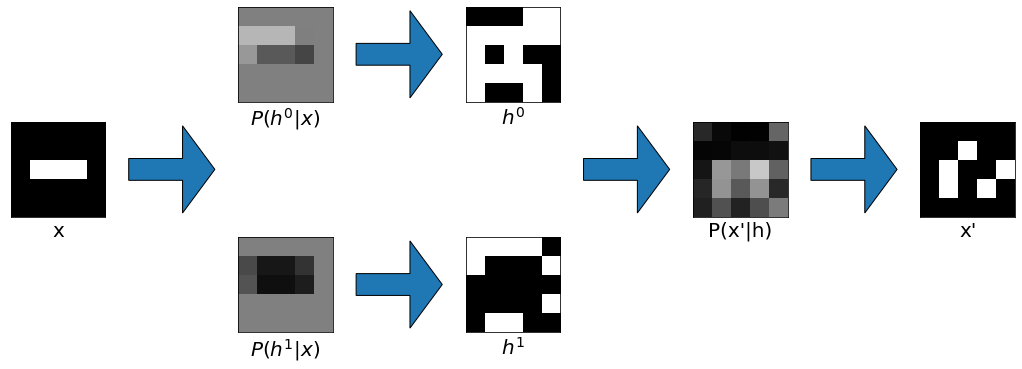

In [380]:
#W, vbias, hbias = [tf.Variable(param) for param in get_param(1 / 100)]
plot_sampling(*gibbs(x_old))

Computing the loss function:  
$\text{diff}(x) = E(x) - F(x)$  
$C = \frac{1}{M} \sum_x \text{diff}(x)$  
$\text{loss} = \sum_x (\text{diff}(x) - C)^2$  
If the parameters where initialized with the analytical solution the loss will only differ slightly from zero because of numerical errors

In [381]:
@tf.function
def compute_loss(x, nll_phys):
    nll_crbm = n_log_like(x)

    diff = nll_phys - nll_crbm
    C = tf.reduce_mean(diff)

    loss = tf.reduce_mean((diff - C) ** 2)
    return loss

print("Train_loss:", compute_loss(states_train, E_phys_train / temp).numpy())
print("Test_loss:", compute_loss(states_test, E_phys_test / temp).numpy())

Tensor("add:0", shape=(512, 3, 3, 2), dtype=float32)
hidden_term_not:  Tensor("Softplus:0", shape=(512, 3, 3, 2), dtype=float32)
hidden_term:  Tensor("Sum:0", shape=(512,), dtype=float32)


ValueError: in user code:

    <ipython-input-381-a61e26f94200>:3 compute_loss  *
        nll_crbm = n_log_like(x)
    <ipython-input-346-064c213d0f85>:10 n_log_like  *
        hbias_test = tf.Variable(np.floor(np.random.random(kernel_dims[0])*10),dtype=floatX) # hidden layer biases
    /opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/variables.py:262 __call__  **
        return cls._variable_v2_call(*args, **kwargs)
    /opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/variables.py:244 _variable_v2_call
        return previous_getter(
    /opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    /opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/eager/def_function.py:730 invalid_creator_scope
        raise ValueError(

    ValueError: tf.function-decorated function tried to create variables on non-first call.


Initialize the adam optimizer, compute the gradients and apply them.

In [46]:
opt = tf.keras.optimizers.Adam()
params = [W, hbias, vbias]
def compute_grad(x, nll_phys):
    ### pass through network
    with tf.GradientTape() as tape:
        loss = compute_loss(x, nll_phys)

    # compute the grad
    grad = tape.gradient(loss, params)
    return grad, loss

@tf.function
def train(x, nll_phys):
    grad, loss = compute_grad(x, nll_phys)

    opt.apply_gradients(zip(grad, params))
    return loss

train(states_train, E_phys_train / temp)

<tf.Tensor: shape=(), dtype=float32, numpy=34.23596>

Everything combined in one class.

In [47]:
class CRBM:
    def __init__(self, kernel_dims=(2, 2), opt=None):
        
        assert len(kernel_dims) == 2
        if opt is None:
            opt = tf.keras.optimizers.Adam()
            
        self.opt = opt
        
        self.kernel_shape = (kernel_dims[1], kernel_dims[1], 1, kernel_dims[0])
        self.kernel_dims = kernel_dims

        multi = np.prod(self.kernel_shape)
        W_np = np.asarray(np.random.randn(*self.kernel_shape) * np.sqrt(2 / multi), dtype=floatX)

        W = tf.Variable(W_np)

        vbias = tf.Variable(np.zeros(1, dtype=floatX))
        hbias = tf.Variable(np.zeros(kernel_dims[0], dtype=floatX))

        self.W = W
        self.hbias = hbias
        self.vbias = vbias

        # Learning parameters
        self.params = [self.W, self.vbias, self.hbias]


    def n_log_like(self, v):
        input4D = periodic_padding(v, self.kernel_dims[1])
        kernels4D = self.W

        # Convolution
        out = tf.nn.conv2d(input4D, kernels4D, strides=1, padding="VALID")
        out += self.hbias[None, None, None, :]

        # Same as softplus(x)=log(1 + exp(x))
        hidden_term_not = tf.math.softplus(out)
        hidden_term = tf.reduce_sum(hidden_term_not, axis=(1, 2, 3))

        visible_term = tf.reduce_sum(v, axis=(1, 2)) * self.vbias[None, :]
        visible_term = tf.reduce_sum(visible_term, axis=1)

        return -hidden_term - visible_term

    def set_analytical_param(self, beta):
        W, vbias, hbias = get_param(beta)
        self.W.assign(W)
        self.hbias.assign(hbias)
        self.vbias.assign(vbias)

    def prop_vis_to_hid(self, v):
        input4D = periodic_padding(v, self.kernel_dims[1])
        kernels4D = self.W
        
        # Convolution
        out = tf.nn.conv2d(input4D, kernels4D, strides=1, padding="VALID")
        
        out += self.hbias[None, None, None, :]
        
        mean_activation = tf.math.sigmoid(out)
        return binomial(mean_activation)
        
    
    def prop_hid_to_vis(self, h):
        input4D = periodic_padding(h, self.kernel_dims[1], deconv=True)
        kernels4D = tf.transpose(self.W[::-1, ::-1], [0, 1, 3, 2])

        # Convolution
        out = tf.nn.conv2d(input4D, kernels4D, strides=1, padding="VALID")
        
        out += self.vbias[None, None, None, :]
        
        mean_activation = tf.math.sigmoid(out)
        return binomial(mean_activation)
    
    @tf.function
    def gibbs(self, state):
        return self.prop_hid_to_vis(self.prop_vis_to_hid(state))
    
    
    @tf.function
    def gibbs_k(self, state, k=1):
        
        i = tf.constant(0)
        cond = lambda i, state: tf.less(i, k)

        def operation(i, state):
            i += 1
            state = self.gibbs(state)
            return i, state

        _, state = tf.while_loop(cond, operation, [i, state])
        
        return state
    
    @tf.function
    def compute_loss(self, x, nll_phys):
        nll_crbm = self.n_log_like(x)

        diff = nll_phys - nll_crbm
        C = tf.reduce_mean(diff)
        
        loss = tf.reduce_mean((diff - C) ** 2)
        return loss
    
    def compute_grad(self, x, nll_phys):
        # compute the grad

        ### pass through network
        with tf.GradientTape() as tape:
            loss = self.compute_loss(x, nll_phys)

        grad = tape.gradient(loss, self.params)
        return grad, loss


    @tf.function
    def train(self, x, nll_phys):
        grad, loss = self.compute_grad(x, nll_phys)

        self.opt.apply_gradients(zip(grad, self.params))
        return loss

# Training

We create an CRBM object and train it. One can see that both the train_loss and the test_loss decrease simulaniously. The expected difference between the two losses should be around $\frac{t_{test}}{t_{train}}=\frac{N_{test}^2}{N^2_{train}}=\frac{50^2}{3^2}=277.77$. Note that our objective is that $F_{RBM}(x)=\beta E(x)+C$.

In [34]:
crbm = CRBM(kernel_dims=(2, 2))

In [35]:
loss_train = []
loss_test = []
epoch = 0

Epoch: 3700 | loss test: 0.029480038210749626| loss train: 0.0001030762869049795| ltest/ltrain: 286.00213623046875


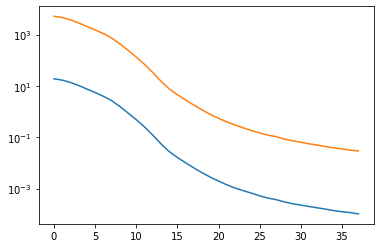

CPU times: user 1min 27s, sys: 8.78 s, total: 1min 36s
Wall time: 57.1 s


In [36]:
%%time
l_train = 10 ** 9
l_test = 10 ** 9

while l_train > 10 ** -4:
    # train
    l_train = 0
    
    for train_s, train_E in train_dataset:
        l_train += crbm.train(train_s, train_E / temp)
    
    l_train = l_train / N_TRAIN_BATCHES
        
    # plot results    
    if epoch % 100 == 0:
        l_test = crbm.compute_loss(states_test, E_phys_test / temp)
        
        loss_train.append(l_train) 
        loss_test.append(l_test)
        
        display.clear_output(wait=True)

        print(
            f"Epoch: {epoch} | loss test: {loss_test[-1]}| loss train: {loss_train[-1]}| ltest/ltrain: {loss_test[-1]/loss_train[-1]}"
        )
        plt.plot(loss_train)
        plt.plot(loss_test)
        plt.yscale("log")
        plt.show()
    epoch += 1

The learned convolutional kernels show the effective interaction between nearest neighbours.

In [375]:
W = crbm.W.numpy()
vmax = np.max(abs(W))

fig, axes = plt.subplots(nrows=1, ncols=2)

axes[0].imshow(W[:, :, 0, 0], vmin =-vmax, vmax=vmax, cmap="seismic")
axes[1].imshow(W[:, :, 0, 1], vmin =-vmax, vmax=vmax, cmap="seismic")

# Deactivate axes
for j in range(2):
    axes[j].set_xticks([])
    axes[j].set_yticks([])
    axes[j].set_xlabel(f'$W^{j}$', fontsize=20)

plt.show()

NameError: name 'crbm' is not defined

# Sampling

A state with $L=40$ is updated $5\times10 ^4$ times using gibbs sampling.  Because the temperature T=1, is well bellow the critical temperature TC=2.269 it converges to the ground state.

In [38]:
L = 200
states = tf.random.uniform((1, L, L, 1))
crbm.set_analytical_param(1 / temp)

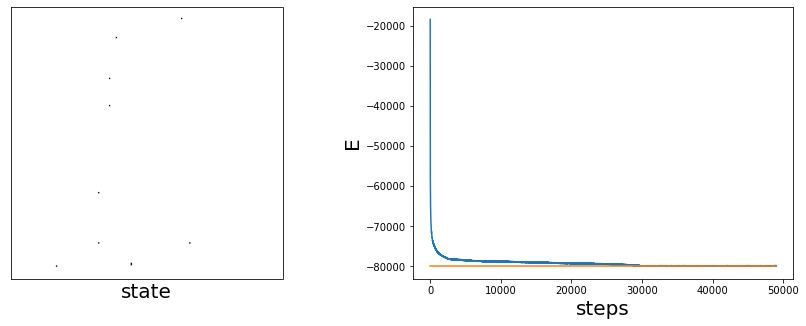

In [39]:
epochs = 5 * 10 ** 4
Es = []
for i in range(epochs):
    states = crbm.gibbs(states)
    Es.append(ising_energy(states)[0])
    
    if i % 1000 == 0:
        display.clear_output(wait=True)
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

        axes[0].imshow(states.numpy()[0, :, :, 0], vmin=0, vmax=1, cmap="gray")
        axes[0].set_xticks([])
        axes[0].set_yticks([])
        axes[0].set_xlabel('state', fontsize=20)


        axes[1].plot(Es)
        axes[1].plot([0, len(Es)], [-2 * L ** 2, -2 * L ** 2])
        axes[1].set_xlabel(f'steps', fontsize=20)
        axes[1].set_ylabel(f'E', fontsize=20)
        display.clear_output(wait=True)
        plt.show()

The minimal energy is $2L^2$

# Thermodynamic constants at different temperatures

Until now we only trained as CRBM at a $T=1$. Train differnt CRBM at different $T$s.




In [40]:
def train(T, crbm=None):
    if crbm is None:
        crbm = CRBM(kernel_dims=(2, 2))
    
    l_train = 10 ** 9
    l_test = 10 ** 9
    epoch = 0
    while l_train > 10 ** -4:
        # train
        l_train = 0

        for train_s, train_E in train_dataset:
            l_train += crbm.train(train_s, train_E / T)
        
        l_train = l_train / N_TRAIN_BATCHES

        # plot results

        if epoch % 100 == 0:
            l_test = crbm.compute_loss(states_test, E_phys_test / T)

            display.clear_output(wait=True)

            print(
                f"Temp: {T} | Epoch: {epoch} | loss test: {l_test}| loss train: {l_train}"
            )
        epoch += 1
   
    return crbm   

In [41]:
Ts = np.linspace(1.5, 3.5, 25)

Train different CRBM's at different temperatures.

In [42]:
#%%time
#crbms = [train(T) for T in Ts]

Faster. Train a CRBM at a temperature, save it, and then modify it's temperature and retrain it at the new temperature.

In [43]:
"""
%%time
crbm = train(Ts[0])
crbms = [crbm]
T_old = Ts[0]
for T in Ts[1:]:
    crbm_new = CRBM(kernel_dims=(2, 2))
    
    crbm_new.W.assign(crbm.W / T * T_old )
    crbm_new.vbias.assign(crbm.vbias / T * T_old)
    crbm_new.hbias.assign(crbm.hbias / T * T_old)
    
    W_old = crbm_new.W.numpy()
    crbm = train(T, crbm_new)
    W_new = crbm.W.numpy()
    
    crbms.append(crbm)
""";

Alternatively, the CRBM can also be initialized directly with the analytical solution so that no further training is necessary.

In [44]:
crbms = []
for T in Ts:
    crbm = CRBM(kernel_dims=(2, 2))
    crbm.set_analytical_param(1 / T)
    crbms.append(crbm)

# Montecarlo Simulations

The functions performs gibbs steps with a CRBM and saves the energy and magnetization in arrays.

In [45]:
def MC(crbm, states, steps, hidden_steps=10):
    Es = np.empty(steps)
    Ms = np.empty(steps)
    
    for i in range(steps):
        states = crbm.gibbs_k(states, k=hidden_steps)
        
        # Get the state out of the gpu
        state_np = states.numpy()
        Es[i] = ising_energy(state_np)[0]
        Ms[i] = (2 * state_np - 1).sum()
              
    return Es, Ms, states

This function will plot the thermodynamic constants

In [46]:
def plot_thermodynamics(Temp, Es, Cvs, mag, susceptibility):
    # ----------------------------------------------------------------------
    # Plot the Energy, Magnetization, Specific Heat and Susceptibility
    # ----------------------------------------------------------------------

    f = plt.figure(figsize=(18, 10), dpi=80, facecolor='w', edgecolor='k')
    xlabel = "T"
    
    sp = f.add_subplot(2, 2, 1)
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel("Energy ", fontsize=20)
    plt.scatter(Temp, Es)

    sp = f.add_subplot(2, 2, 2)
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel("Magnetization ", fontsize=20)
    plt.scatter(Temp, abs(np.array(mag)))
    plt.axvline(x=2.269)
    
    sp = f.add_subplot(2, 2, 3)
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel("Specific Heat ", fontsize=20)

    plt.scatter(Temp, Cvs)
    plt.axvline(x=2.269)

    sp = f.add_subplot(2, 2, 4);
    plt.xlabel(xlabel, fontsize=20);
    plt.ylabel("Susceptibility", fontsize=20);
    
    plt.scatter(Temp, susceptibility)
    plt.axvline(x=2.269)

    plt.show()

Initialize the step that will be used during the MC. There is an oportunity for parallelization in the Gpu if severall states are updated in the simulation. For simplicity only one states is used.



In [47]:
L = 25
states = tf.random.uniform((1, L, L, 1))

We start with the highest temperature and slowly lower it. First there is a warmup phase and then thermodynamic constants are recorded.

Temp:  1.5


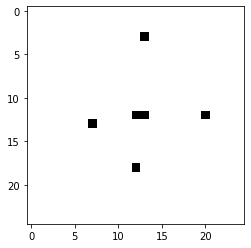

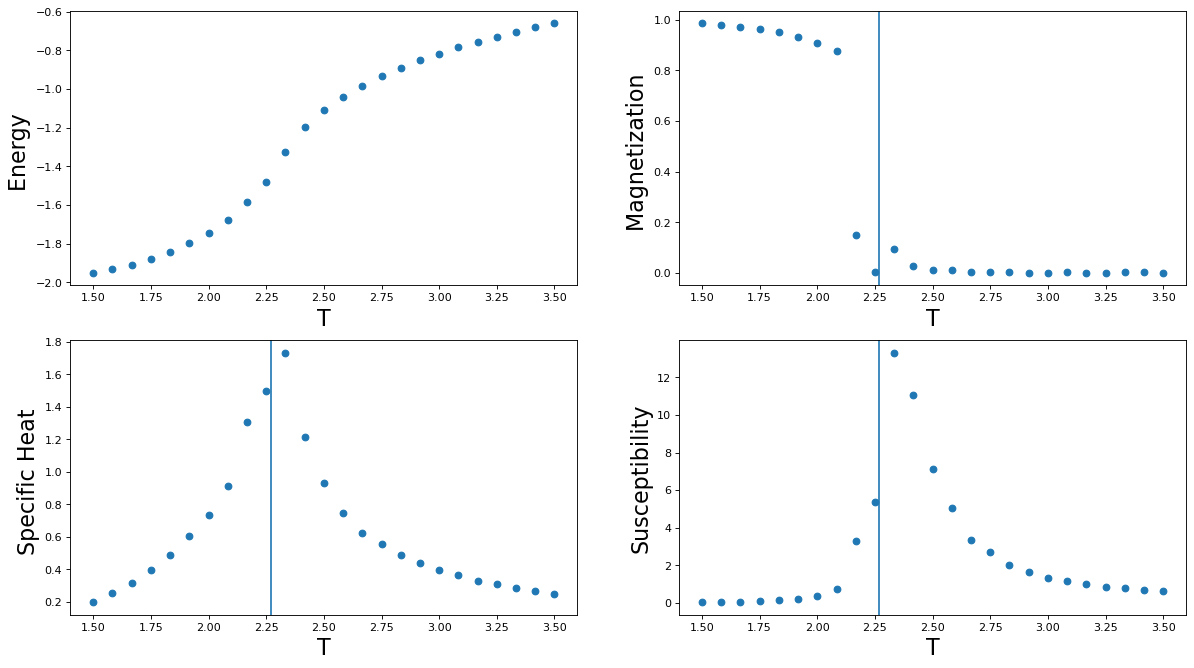

CPU times: user 16min 9s, sys: 1min 45s, total: 17min 54s
Wall time: 11min 56s


In [48]:
%%time

energy = []
magnetization = []
CV = []
susceptibility = []

e, m, states = MC(crbms[-1], states, 2 * 10 ** 4)
for i, crbm in enumerate(crbms[::-1]):
    # Warmup
    e, m, states = MC(crbm, states, 10 ** 3)
    
    # Mc Simulation
    e, m, states = MC(crbm, states,  2 * 10 ** 4)
    
    # Computing expectaion values
    e1 = e.mean()
    e2 = (e ** 2).mean()
    
    m1 = m.mean()
    absm1= abs(m).mean()
    m2 = (m ** 2).mean()
    
    
    energy.append(e1 / L ** 2)
    magnetization.append(m1 / L ** 2)
    CV.append( (e2 - e1 ** 2) / Ts[-i - 1] ** 2 / L ** 2 )
    susceptibility.append( (m2 - absm1 ** 2) / Ts[-i - 1] / L ** 2 )
    
    
    display.clear_output(wait=True)
    print("Temp: ", Ts[-i -1])
    plt.imshow(states.numpy()[0, :, :, 0], vmin=0, vmax=1, cmap="gray")
    plt.show()
    
    # Plot thermodynamics
    plot_thermodynamics(Ts[-i - 1:], energy[::-1], CV[::-1], magnetization[::-1], susceptibility[::-1])

Above you can see that the Magnetization colapses to 0 after the critical temperature $T_c=2.269$ and that the specific heat is maximal around $T_c$ as expected.

In [49]:
t1 = time.time()
(t1 - t0) / 60

34.9485397140185

In [ ]:
d